In [1]:
import numpy as np
import time
from pynq import Overlay, allocate
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl

np.set_printoptions(suppress=True)
mpl.rcParams['axes.unicode_minus'] = False  # 显示负号
# help(time)

### 产生待处理的信号

In [2]:
# 采样点选择2000个，因为设置的信号频率分量最高为600赫兹，根据采样定理知采样频率要大于信号频率2倍，所以这里设置采样频率为2000赫兹（即一秒内有2000个采样点，一样意思的）
x = np.linspace(0, 1, 2048)

# 设置需要采样的信号，频率分量有200，400和600
y = 7 * np.sin(2 * np.pi * 200 * x) + 5 * np.sin(2 * np.pi * 400 * x) + 3 * np.sin(2 * np.pi * 600 * x)

### 软件方法计算频谱及可视化

In [3]:
start = time.time()
fft_y = fft(y)  # 快速傅里叶变换
end = time.time()
print('FFT caculated by cpu wastes  %d us' %((end-start)*1000000))

FFT caculated by cpu wastes  2277 us


In [4]:
N = 2048
x = np.arange(N)  # 频率个数
half_x = x[range(int(N / 2))]  # 取一半区间

In [5]:
abs_y = np.abs(fft_y)  # 取复数的绝对值，即复数的模(双边频谱)
normalization_y = abs_y / N  # 归一化处理（双边频谱）
normalization_half_y = normalization_y[range(int(N / 2))]  # 由于对称性，只取一半区间（单边频谱）

### 绘制原始波形

Text(0.5, 1.0, 'Original waveform')

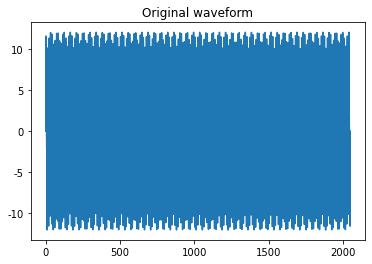

In [6]:
plt.plot(x, y)
plt.title('Original waveform')

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Bilateral amplitude spectrum (amplitude absolute value not calculated)')

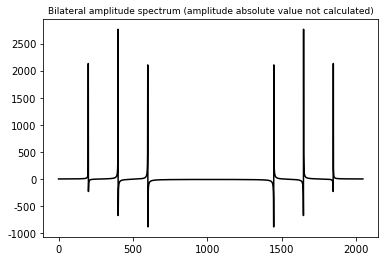

In [7]:
plt.plot(x, fft_y, 'black')
plt.title('Bilateral amplitude spectrum (amplitude absolute value not calculated)', fontsize=9, color='black')

Text(0.5, 1.0, 'Bilateral amplitude spectrum (not normalized)')

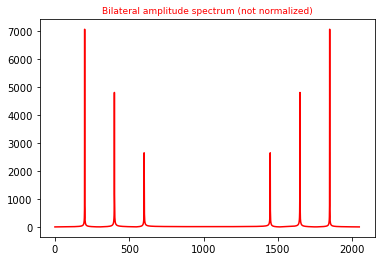

In [8]:
plt.plot(x, abs_y, 'r')
plt.title('Bilateral amplitude spectrum (not normalized)', fontsize=9, color='red')

Text(0.5, 1.0, 'Bilateral amplitude spectrum (normalized)')

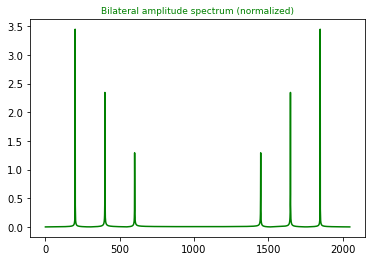

In [9]:
plt.plot(x, normalization_y, 'g')
plt.title('Bilateral amplitude spectrum (normalized)', fontsize=9, color='green')

Text(0.5, 1.0, 'Unilateral amplitude spectrum (normalized)')

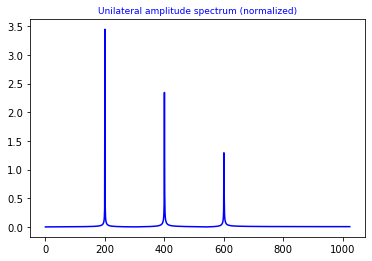

In [10]:
plt.plot(half_x, normalization_half_y, 'blue')
plt.title('Unilateral amplitude spectrum (normalized)', fontsize=9, color='blue')

### 调用硬件进行频谱计算

In [13]:
# x = np.loadtxt("wave.txt", dtype=np.float32)
TWO_TO_THE_POWER_OF_N_MAX = 11
NFFT = 1 << TWO_TO_THE_POWER_OF_N_MAX

In [14]:
overlay = Overlay("fft.bit")
# xlnk = Xlnk()
in_buffer = allocate(shape=(NFFT,), dtype=np.csingle)
out_buffer = allocate(shape=(NFFT,), dtype=np.csingle)
data = y[:NFFT].astype(np.csingle)

#overlay = Overlay("fft_float_pynq_z1.bit")
#in_buffer = xlnk.cma_array(shape=(NFFT,), dtype=np.float32)
#out_buffer = xlnk.cma_array(shape=(NFFT*2,), dtype=np.float32)
#data = x[:NFFT].astype(np.float32)

fft_ip = overlay.hls_fft_0
help(fft_ip)
dma_ip = overlay.axi_dma_0
help(dma_ip)

fft_ip.write(0x10, TWO_TO_THE_POWER_OF_N_MAX)

Help on DefaultIP in module pynq.overlay object:

class DefaultIP(builtins.object)
 |  DefaultIP(description)
 |  
 |  Driver for an IP without a more specific driver
 |  
 |  This driver wraps an MMIO device and provides a base class
 |  for more specific drivers written later. It also provides
 |  access to GPIO outputs and interrupts inputs via attributes. More specific
 |  drivers should inherit from `DefaultIP` and include a
 |  `bindto` entry containing all of the IP that the driver
 |  should bind to. Subclasses meeting these requirements will
 |  automatically be registered.
 |  
 |  Attributes
 |  ----------
 |  mmio : pynq.MMIO
 |      Underlying MMIO driver for the device
 |  _interrupts : dict
 |      Subset of the PL.interrupt_pins related to this IP
 |  _gpio : dict
 |      Subset of the PL.gpio_dict related to this IP
 |  
 |  Methods defined here:
 |  
 |  __init__(self, description)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  read(se

In [15]:
start = time.time()
def fft_on_hw(fft_ip, dma_ip, input_data):    
#     Xlnk.cma_memcopy(in_buffer, input_data, in_buffer.data.nbytes)
    np.copyto(in_buffer, input_data)
    print(type(in_buffer.data.nbytes))
    dma_ip.sendchannel.transfer(in_buffer)
    dma_ip.recvchannel.transfer(out_buffer)
    fft_ip.write(0x00, 0x01)
    while not ((fft_ip.read(0x00) >> 1) & 0x01):
        continue
    dma_ip.sendchannel.wait()
    dma_ip.recvchannel.wait() 
    return out_buffer.copy()
end = time.time()
print('FFT caculated by FPGA wastes ' + str((end-start)*1000000) + ' us')

FFT caculated by FPGA wastes 2123.3558654785156 us


In [ ]:
result = fft_on_hw(fft_ip, dma_ip, data)

<class 'int'>


Text(0.5, 1.0, 'Unilateral amplitude spectrum (normalized) with hardware')

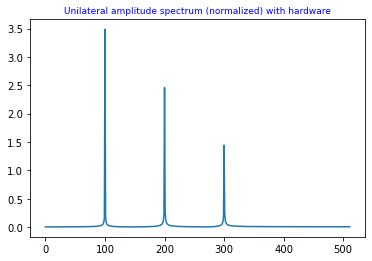

In [12]:
plt.plot(np.arange(NFFT/2),np.abs(result[range(int(NFFT/2))])/NFFT)
plt.title('Unilateral amplitude spectrum (normalized) with hardware', fontsize=9, color='blue')